In [1]:
import os
import xarray as xr
import numpy as np
import geopandas as gpd
import xesmf as xe
import pymannkendall as mk
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import seaborn as sns

ERROR 1: PROJ: proj_create_from_database: Open of /dartfs-hpc/rc/home/0/f004260/.conda/envs/arg24/share/proj failed


In [2]:
root_dir = '/dartfs-hpc/rc/lab/C/CMIG'
project_dir = os.path.join(root_dir,'damages','county')
grace_dir = os.path.join(project_dir,'data','interim','grace_gapfilled')

In [4]:
csr = xr.open_dataset(os.path.join(grace_dir,'grace-csr.nc')).sel(time=slice("2003","2024")).sel(lat=slice(23,51),lon=slice(-126,-66))
jpl = xr.open_dataset(os.path.join(grace_dir,'grace-jpl.nc')).sel(time=slice("2003","2024")).sel(lat=slice(23,51),lon=slice(-126,-66))
clsm = xr.open_dataset(os.path.join(grace_dir,'clsm-grace.nc')).sel(time=slice("2003","2024")).sel(lat=slice(23,51),lon=slice(-126,-66))


In [5]:
def linear_trend(y):
    x = np.arange(len(y))
    isna = np.isnan(y)
    x = x[~isna]
    y = y[~isna]
    if len(y)==0:
        return np.nan
    else:
        return np.polyfit(x,y,1)[0]

In [6]:
csr_tr = xr.apply_ufunc(linear_trend,
                        csr['twsa'],
                        input_core_dims=[['time']],
                        vectorize=True)
csr_tr = len(csr['time'])*csr_tr

In [7]:
jpl_tr = xr.apply_ufunc(linear_trend,
                        jpl['twsa'],
                        input_core_dims=[['time']],
                        vectorize=True)

jpl_tr = len(jpl['time'])*jpl_tr

In [8]:
clsm_tr = xr.apply_ufunc(linear_trend,
                        clsm['TWS_tavg'],
                        input_core_dims=[['time']],
                        vectorize=True)

clsm_tr = len(clsm['time'])*clsm_tr

In [9]:
ref_ds = xr.open_dataset(os.path.join(root_dir,'Data','Observations','CPC','ppt_conus','precip.V1.0.mon.mean.nc'))

csr_regridder = xe.Regridder(csr_tr,ref_ds,'bilinear')
csr_tr = csr_regridder(csr_tr)
csr_tr = csr_tr.where(ref_ds['precip'].isel(time=0).notnull())

jpl_regridder = xe.Regridder(jpl_tr,ref_ds,'bilinear')
jpl_tr = jpl_regridder(jpl_tr)
jpl_tr = jpl_tr.where(ref_ds['precip'].isel(time=0).notnull())

clsm_regridder = xe.Regridder(clsm_tr,ref_ds,'bilinear')
clsm_tr = clsm_regridder(clsm_tr)
clsm_tr = clsm_tr.where(ref_ds['precip'].isel(time=0).notnull())

In [10]:
csr_tr.name = 'tws_tr'
jpl_tr.name = 'tws_tr'
clsm_tr.name = 'tws_tr'
all_tr = xr.concat([csr_tr,jpl_tr,clsm_tr],dim='product').to_dataset()

In [11]:
all_tr['agree'] = np.sign(all_tr['tws_tr']).sum('product')
all_tr = all_tr.where(all_tr['tws_tr'].mean('product').notnull())

In [12]:
tr_levels = np.arange(-300,301,25)
tr_cols = sns.color_palette("BrBG",len(tr_levels)+1)
tr_cmap = mpl.colors.ListedColormap(tr_cols[1:-1])
tr_cmap.set_under(tr_cols[0])
tr_cmap.set_over(tr_cols[-1])
tr_norm = plt.Normalize(vmin=-300,vmax=300)

In [13]:
gdf = gpd.read_file(os.path.join(project_dir,'data','interim','cnty_bnds_fixed'))
gdf_state = gdf.dissolve(by='state')

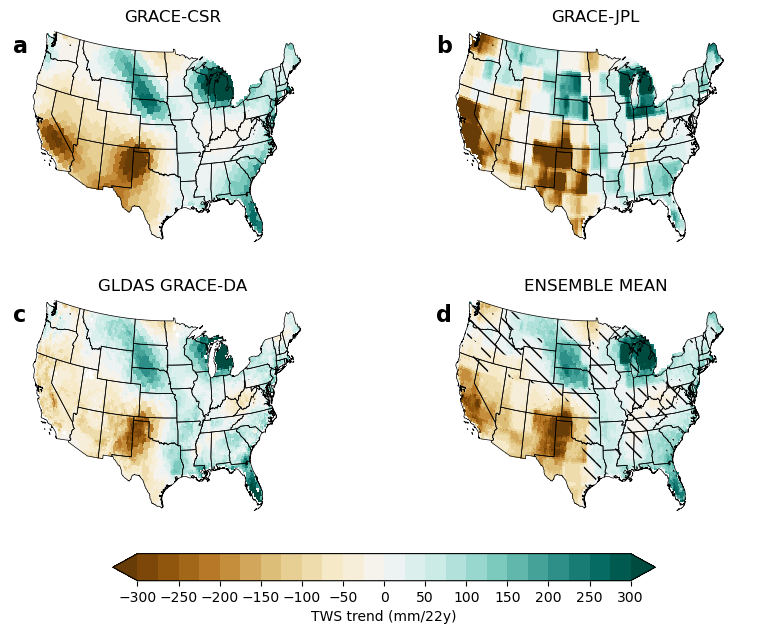

In [15]:
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(nrows=2,ncols=2,figure=fig)
ax1 = plt.subplot(gs[0,0],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
ax2 = plt.subplot(gs[0,1],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
ax3 = plt.subplot(gs[1,0],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
ax4 = plt.subplot(gs[1,1],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
csr_tr.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap=tr_cmap,norm=tr_norm,add_colorbar=False)
jpl_tr.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap=tr_cmap,norm=tr_norm,add_colorbar=False)
clsm_tr.plot(ax=ax3,transform=ccrs.PlateCarree(),cmap=tr_cmap,norm=tr_norm,add_colorbar=False)
all_tr['tws_tr'].mean('product').plot(ax=ax4,transform=ccrs.PlateCarree(),cmap=tr_cmap,norm=tr_norm,add_colorbar=False)
all_tr['agree'].plot.contourf(ax=ax4,transform=ccrs.PlateCarree(),levels=[-3.5,-2.5,2.5,3.5],colors='none',hatches=[None,'\\\\',None],add_colorbar=False)
titles = ['GRACE-CSR','GRACE-JPL','GLDAS GRACE-DA','ENSEMBLE MEAN']
labels = ['a','b','c','d']
for i,ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.set_extent([-123, -68, 24, 49],ccrs.PlateCarree())
    gdf_state.geometry.boundary.plot(ax=ax,transform=ccrs.PlateCarree(),edgecolor='black',lw=0.5)
    ax.set_frame_on(False)
    ax.title.set_text(titles[i])
    ax.text(0.01,0.98,labels[i],ha='left',va='top',fontsize=16,fontweight='bold',transform=ax.transAxes)

    
tr_cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=tr_norm,cmap=tr_cmap),ax=[ax1,ax2,ax3,ax4],orientation='horizontal',ticks=np.arange(-300,301,50),extend='both',shrink=0.7,pad=0.05,)
tr_cbar.ax.set_xlabel('TWS trend (mm/22y)')
plt.savefig(os.path.join(project_dir,'figures','supp_mat','tws_trend.png'),bbox_inches='tight',dpi=350)
plt.savefig(os.path.join(project_dir,'figures','supp_mat','tws_trend.pdf'),bbox_inches='tight',dpi=350)
plt.show()

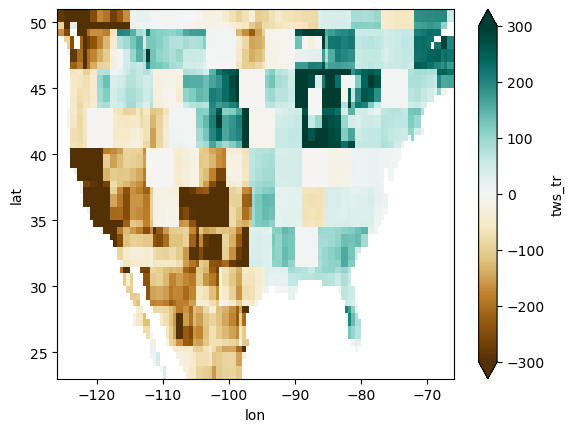

In [33]:
jpl_tr.plot(cmap='BrBG',vmin=-300,vmax=300)